In [ ]:

import numpy as np
import keras
import seaborn as sns
from matplotlib import pyplot as mplt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline
import tensorflow as tf


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


(32, 32, 3, 73257)
(32, 32, 3, 26032)
(73257, 32, 32, 3)
(26032, 32, 32, 3)


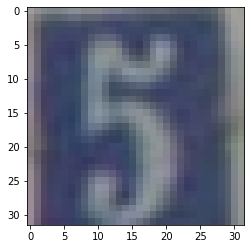

Label:  [5]
Min: 0.0, Max: 255.0


In [ ]:
#loading the data and preprocess
np.random.seed(20)
am_epoch=10
cnn_epoch=50
train_dataset = loadmat('/content/drive/My Drive/ALDA/train_32x32.mat')
test_dataset = loadmat('/content/drive/My Drive/ALDA/test_32x32.mat')

# Load images and labels

img_train = np.array(train_dataset['X'])
img_test = np.array(test_dataset['X'])

trainLbl = train_dataset['y']
testLbl = test_dataset['y']

# Check the shape of the data
print(img_train.shape)
print(img_test.shape)

# Fix the axes of the images

img_train = np.moveaxis(img_train, -1, 0)
img_test = np.moveaxis(img_test, -1, 0)

print(img_train.shape)
print(img_test.shape)

# Plot a random image and its label
mplt.imshow(img_train[13529])
mplt.show()

print('Label: ', trainLbl[13529])

# Convert train and test images into 'float64' type
img_train = img_train.astype('float64')
img_test = img_test.astype('float64')
# Convert train and test labels into 'int64' type

trainLbl = trainLbl.astype('int64')
testLbl = testLbl.astype('int64')
# Normalize the images data

print('Min: {}, Max: {}'.format(img_train.min(), img_train.max()))
#normalise the images
img_test /= 255.0
img_train /= 255.0




In [ ]:
# One-hot encoding of train and test labels
binaryform = LabelBinarizer()
trainLbl = binaryform.fit_transform(trainLbl)
testLbl = binaryform.fit_transform(testLbl)

# Split train data into train and validation
X_train_input, X_validation_input, Y_train_label, Y_validation_label = train_test_split(img_train, trainLbl,test_size=0.15, random_state=22)
Y_validation_label.shape

(10989, 10)

In [ ]:

#CNN Model
# Data augmentation
Imgdatagen = ImageDataGenerator(rotation_range=7, zoom_range=[0.93, 1.02],height_shift_range=0.12,shear_range=0.13)

# Define auxillary model
keras.backend.clear_session()

nn = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu',input_shape=(32, 32, 3)), keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'), keras.layers.MaxPooling2D((2, 2)),keras.layers.Dropout(0.3),
   
    keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),keras.layers.BatchNormalization(), 
    keras.layers.Conv2D(64, (3, 3), padding='same',  activation='relu'), keras.layers.MaxPooling2D((2, 2)),keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3, 3), padding='same',activation='relu'),keras.layers.MaxPooling2D((2, 2)),keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.4),    
    keras.layers.Dense(10,  activation='softmax')
])

learningrate = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 10))
opt =tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)
nn.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])


                              


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Fit model in order to determine best learning rate
model_train = nn.fit_generator(Imgdatagen.flow(X_train_input, Y_train_label, batch_size=128), epochs=am_epoch, validation_data=(X_validation_input, Y_validation_label),callbacks=[learningrate])


Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


487/487 [==============================] - 44s 67ms/step - loss: 2.3197 - accuracy: 0.1552 - val_loss: 2.2100 - val_accuracy: 0.1965 - lr: 1.0000e-04
Epoch 2/10
487/487 [==============================] - 32s 66ms/step - loss: 2.1112 - accuracy: 0.2316 - val_loss: 1.8262 - val_accuracy: 0.3636 - lr: 1.2589e-04
Epoch 3/10
487/487 [==============================] - 32s 65ms/step - loss: 1.5083 - accuracy: 0.4895 - val_loss: 0.8309 - val_accuracy: 0.7541 - lr: 1.5849e-04
Epoch 4/10
487/487 [==============================] - 32s 66ms/step - loss: 1.0502 - accuracy: 0.6579 - val_loss: 0.5261 - val_accuracy: 0.8389 - lr: 1.9953e-04
Epoch 5/10
487/487 [==============================] - 32s 65ms/step - loss: 0.7836 - accuracy: 0.7510 - val_loss: 0.4264 - val_accuracy: 0.8710 - lr: 2.5119e-04
Epoch 6/10
487/487 [==============================] - 32s 65ms/step - loss: 0.6353 - accuracy: 0.8039 - val_loss: 0.3433 - val_accuracy: 0.8969 - lr: 3.1623e-04
Epoch 7/10
487/487 [=========================

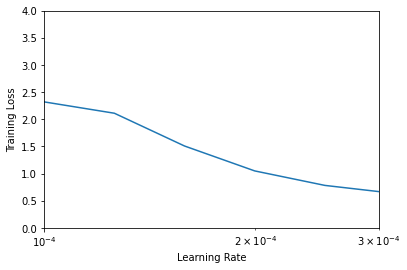

In [ ]:
# Plot Learning Rate vs. Loss
mplt.semilogx(model_train.history['lr'], model_train.history['loss'])
mplt.axis([1e-4, 3*1e-4, 0, 4])
mplt.ylabel('Training Loss')
mplt.xlabel('Learning Rate')
mplt.show()

In [ ]:
# Define actual model
keras.backend.clear_session()
cnn = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu',input_shape=(32, 32, 3)), keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),keras.layers.MaxPooling2D((2, 2)), keras.layers.Dropout(0.3),
    keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3, 3), padding='same',activation='relu'),keras.layers.MaxPooling2D((2, 2)),keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (3, 3), padding='same',activation='relu'),keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3, 3), padding='same',activation='relu'),keras.layers.MaxPooling2D((2, 2)),keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.4),    
    keras.layers.Dense(10,  activation='softmax')
])

early_stop = keras.callbacks.EarlyStopping(patience=8)
opt =tf.keras.optimizers.Adam(lr=1e-3, amsgrad=True)
cnn_checkpoint = keras.callbacks.ModelCheckpoint('/content/drive/My Drive/ALDA/best_cnn.h5',  save_best_only=True)
cnn.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

cnn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        1

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Fit model in order to make predictions
model_train = cnn.fit_generator(Imgdatagen.flow(X_train_input, Y_train_label, batch_size=128),epochs=cnn_epoch, validation_data=(X_validation_input, Y_validation_label),callbacks=[early_stop, cnn_checkpoint])

# Evaluate train and validation accuracies and losses
train_data_accuracy = model_train.history['accuracy']
validation_data_accuracy = model_train.history['val_accuracy']

train_dataset_loss = model_train.history['loss']
valid_dataset_loss = model_train.history['val_loss']


Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


487/487 [==============================] - 34s 68ms/step - loss: 2.0931 - accuracy: 0.2495 - val_loss: 1.6129 - val_accuracy: 0.4716
Epoch 2/50
487/487 [==============================] - 32s 66ms/step - loss: 1.5682 - accuracy: 0.4261 - val_loss: 0.9349 - val_accuracy: 0.7308
Epoch 3/50
487/487 [==============================] - 32s 67ms/step - loss: 1.1669 - accuracy: 0.5780 - val_loss: 0.4345 - val_accuracy: 0.8732
Epoch 4/50
487/487 [==============================] - 32s 66ms/step - loss: 0.5647 - accuracy: 0.8325 - val_loss: 0.3487 - val_accuracy: 0.8984
Epoch 5/50
487/487 [==============================] - 32s 67ms/step - loss: 0.4296 - accuracy: 0.8773 - val_loss: 0.2968 - val_accuracy: 0.9171
Epoch 6/50
487/487 [==============================] - 32s 66ms/step - loss: 0.3720 - accuracy: 0.8942 - val_loss: 0.2739 - val_accuracy: 0.9265
Epoch 7/50
487/487 [==============================] - 32s 65ms/step - loss: 0.3412 - accuracy: 0.9028 - val_loss: 0.2876 - val_accuracy: 0.9175
Epo

In [ ]:
# Visualize epochs vs. train and validation accuracies and losses

mplt.figure(figsize=(20, 10))

mplt.subplot(1, 2, 1)
mplt.plot(train_data_accuracy, label='Training dataset Accuracy')
mplt.plot(validation_data_accuracy, label='Validation dataset Accuracy')
mplt.legend()
mplt.title('Epochs vs. Training dataset and Validation dataset Accuracy')
    
mplt.subplot(1, 2, 2)
mplt.plot(train_dataset_loss, label='Training dataset Loss')
mplt.plot(valid_dataset_loss, label='Validation dataset  Loss')
mplt.legend()
mplt.title('Epochs vs. Trainingdataset and Validation dataset Loss')

mplt.show()




In [ ]:
# Evaluate model on test data
test_loss, test_acc = cnn.evaluate(x=img_test, y=testLbl, verbose=0)

print('Test accuracy is: {:0.4f} \nTest loss is: {:0.4f}'.format(test_acc, test_loss))

Test accuracy is: 0.9545 
Test loss is: 0.1895


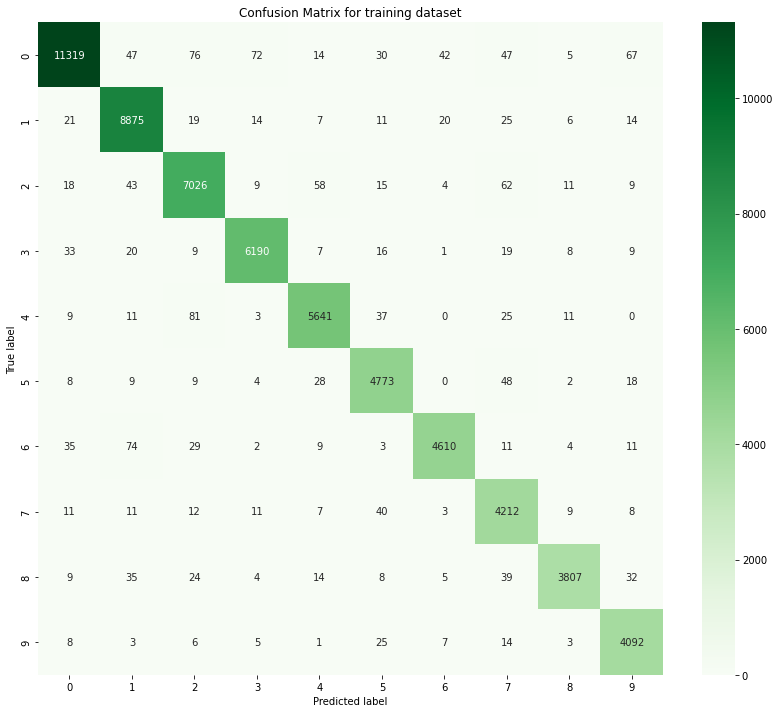

In [ ]:
#Visualizations and insights
# Get predictions and apply inverse transformation to the labels
y_predicted = cnn.predict(X_train_input)
y_predicted = binaryform.inverse_transform(y_predicted, binaryform.classes_)
Y_train_label = binaryform.inverse_transform(Y_train_label, binaryform.classes_)

# Plot the confusion matrix
matrix = confusion_matrix(Y_train_label, y_predicted, labels=binaryform.classes_)

fig, ax = mplt.subplots(figsize=(14, 12))
sns.heatmap(matrix, annot=True, cmap='Greens', fmt='d', ax=ax)
mplt.title('Confusion Matrix for training dataset')
mplt.xlabel('Predicted label')
mplt.ylabel('True label')
mplt.show()




0.9519504200408896
0.954479102642901
0.954521567249528


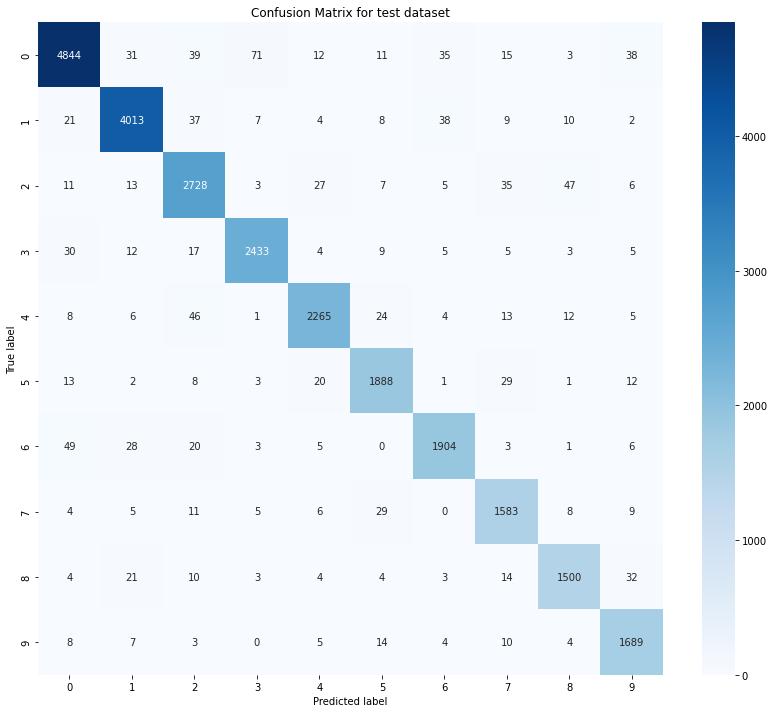

{'divide': 'ignore', 'invalid': 'ignore', 'over': 'ignore', 'under': 'ignore'}

In [ ]:
np.seterr(all='ignore')
import sklearn as sk

y_predicted = cnn.predict(img_test)
y_predicted = binaryform.inverse_transform(y_predicted, binaryform.classes_)
y_test = binaryform.inverse_transform(testLbl, binaryform.classes_)

# Plot the confusion matrix
matrix = confusion_matrix(y_test, y_predicted, labels=binaryform.classes_)
print(sk.metrics.f1_score(y_test, y_predicted, average='macro'))
print(sk.metrics.f1_score(y_test, y_predicted, average='micro'))
print(sk.metrics.f1_score(y_test, y_predicted, average='weighted'))
fig, ax = mplt.subplots(figsize=(14, 12))
sns.heatmap(matrix, annot=True, cmap='Blues', fmt='d', ax=ax)
mplt.title('Confusion Matrix for test dataset')
mplt.xlabel('Predicted label')
mplt.ylabel('True label')
mplt.show()
np.seterr(all='ignore')